In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Any, Dict

import numpy as np
import scipy.sparse as sp
import torch
import torch.nn.functional as F
from torch_sparse import SparseTensor
from jaxtyping import Float, Integer
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
import os

from src.graph_models.csbm import CSBM
from src.models.common import get_diffusion
from src.models.ntk import NTK
from src.attacks import create_attack
from common import configure_hardware, get_graph, \
    count_edges_for_idx, calc_kernel_means, plot_ntk_model_diff
from src import utils

In [29]:
# Data
data_dict = dict(
    classes = 2,
    n = 1000,
    n_per_class_trn = 300,
    n_per_class_labeled = 300,
    sigma = 1,
    avg_within_class_degree = 1.58 * 2,
    avg_between_class_degree = 0.37 * 2,
)
#assert data_dict["n_per_class_trn"] == data_dict["n_per_class_labeled"] # PRBCD can't handle otherwise
K = 1
seed = 1
# Model
model_dict_gcn = {
    "label": "GCN",
    "model": "GCN",
    "normalization": "row_normalization",
    "depth": 1,
}
model_dict_softmedoid = {
    "label": "SoftM_T1",
    "model": "SoftMedoid",
    "normalization": "row_normalization",
    "depth": 1,
    "T": 1
}
model_dict = model_dict_softmedoid
model_dict_l = [model_dict_gcn, model_dict_softmedoid]
attack_params = {
    "attack": "prbcd",
    "search_space_size": 50_000,
    "epochs": 10,
    "fine_tune_epochs": 0
}
# Attack
eps_l = [0, 0.01, 0.025, 0.05, 0.10, 0.25, 0.50, 1, 2.5, 5, 10]
# other
device = "cpu"
dtype = torch.float64
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [30]:
rng = np.random.Generator(np.random.PCG64(seed))
device_ = configure_hardware(device, seed)
data_dict["K"] = K
# Sample
X, A, y = get_graph(data_dict, seed=seed)
X = torch.tensor(X, dtype=dtype, device=device_)
A = torch.tensor(A, dtype=dtype, device=device_)
y = torch.tensor(y, device=device_)
# Trn / Test Split
n_cls0 = sum(y == 0)
n = len(y)
idx_cls0 = rng.permutation(np.arange(n_cls0))
idx_cls1 = rng.permutation(np.arange(n_cls0, n))
n_trn = data_dict["n_per_class_trn"]
n_labeled = data_dict["n_per_class_labeled"]
idx_labeled = np.concatenate((idx_cls0[:n_labeled], idx_cls1[:n_labeled]))
idx_unlabeled = np.concatenate((idx_cls0[n_labeled:], idx_cls1[n_labeled:]))
idx_target = np.concatenate((idx_cls0[n_trn:], idx_cls1[n_trn:]))
idx_labeled.sort()
idx_unlabeled.sort()
idx_target.sort()
#
#ntk = NTK(X, A, model_dict)
#adj = SparseTensor.from_dense(A)
#edge_index_rows, edge_index_cols, edge_weight = adj.coo()
#edge_index = torch.stack([edge_index_rows, edge_index_cols], dim=0).to(device)
#edge_weight = edge_weight.to(device)
#edge_weight.requires_grad = True
#A = torch.sparse_coo_tensor(edge_index, edge_weight, 2 * [n]).to_dense()
A.requires_grad = True
t = NTK(X, A, model_dict).ntk
ntk_labeled = t[idx_labeled,:][:,idx_labeled]
ntk_unlabeled = t[idx_unlabeled,:][:,idx_labeled]
M = torch.linalg.solve(ntk_labeled, ntk_unlabeled, left=False)
y_pred = torch.matmul(M, (y[idx_labeled] * 2 - 1).to(dtype=torch.float64)) 
print(utils.accuracy(y_pred, y, idx_unlabeled))
loss = F.binary_cross_entropy_with_logits(y_pred, y[idx_unlabeled].to(dtype=torch.float64))
print(loss)
loss.backward()
print(A.grad)
#print(edge_weight.grad)
#print(edge_weight.grad.shape)

tensor(0.7875)
tensor(0.5269, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)


In [12]:
rng = np.random.Generator(np.random.PCG64(seed))
device_ = configure_hardware(device, seed)
data_dict["K"] = K
# Sample
X, A, y = get_graph(data_dict, seed=seed)
X = torch.tensor(X, dtype=dtype, device=device_)
A = torch.tensor(A, dtype=dtype, device=device_)
y = torch.tensor(y, device=device_)
# Trn / Test Split
n_cls0 = sum(y == 0).cpu().item()
n = len(y)
idx_cls0 = rng.permutation(np.arange(n_cls0))
idx_cls1 = rng.permutation(np.arange(n_cls0, n))
n_trn = data_dict["n_per_class_trn"]
n_labeled = data_dict["n_per_class_labeled"]
idx_labeled = np.concatenate((idx_cls0[:n_labeled], idx_cls1[:n_labeled]))
idx_unlabeled = np.concatenate((idx_cls0[n_labeled:], idx_cls1[n_labeled:]))
idx_target = np.concatenate((idx_cls0[n_trn:], idx_cls1[n_trn:]))
idx_unlabeled.sort()
idx_target.sort()
# Init Attack
ntk = NTK(X, A, model_dict)
attack = create_attack(idx_target, X, A, y, idx_labeled, idx_unlabeled, 
                       attack_params, seed, ntk, device=device_)
eps=0.1
n_pert = int(round(eps * count_edges_for_idx(A.cpu(), idx_target)))
edge_index, edge_weight = attack.attack(n_pert)
A_pert = torch.sparse_coo_tensor((edge_index, edge_weight), 2 * [n]).to_dense()
# Computing NTK
#ntk_l = list()
#for eps in eps_l:
#    n_pert = int(round(eps * count_edges_for_idx(A, idx_target)))
#    A_pert = attack.attack(n_pert)
#    ntk_l.append(NTK(X, A_pert, model_dict))

  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.4765, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor([1.0000e-07, 1.0000e-07, 1.0000e-07,  ..., 1.0000e-07, 1.0000e-07,
        1.0000e-07], requires_grad=True)
tensor([nan, nan, nan,  ..., nan, nan, nan])


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
y_pred = ntk(X, A, y, idx_labeled, idx_unlabeled)
utils.accuracy(y_pred, y, idx_unlabeled)
y_pred = ntk(X, A_pert, y, idx_labeled, idx_unlabeled)
utils.accuracy(y_pred, y, idx_unlabeled)

In [10]:
# NTK inverse is unstable!
M2 = ntk_unlabeled.matmul(torch.linalg.inv(ntk_labeled))
torch.dist(ntk_labeled @ torch.linalg.inv(ntk_labeled), torch.eye(n_labeled*2))

tensor(3.6705e+20, dtype=torch.float64)

In [9]:
M2.size()

torch.Size([400, 600])

In [35]:
t[idx_unlabeled,:][:,idx_labeled].shape

torch.Size([400, 600])

In [22]:
ntk_dict = dict()
device_ = configure_hardware(device, seed)
data_dict["K"] = K
for model_dict in model_dict_l:
    # Sample
    X, A, y = get_graph(data_dict, seed=seed, sort=True)
    X = torch.tensor(X, dtype=dtype, device=device_)
    A = torch.tensor(A, dtype=dtype, device=device_)
    y = torch.tensor(y, device=device_)
    # Trn / Test Split
    n_cls0 = sum(y == 0)
    n = len(y)
    idx_cls0 = rng.permutation(np.arange(n_cls0))
    idx_cls1 = rng.permutation(np.arange(n_cls0, n))
    n_trn = data_dict["n_per_class_trn"]
    n_labeled = data_dict["n_per_class_labeled"]
    idx_labeled = np.concatenate((idx_cls0[:n_labeled], idx_cls1[:n_labeled]))
    idx_unlabeled = np.concatenate((idx_cls0[n_labeled:], idx_cls1[n_labeled:]))
    idx_target = np.concatenate((idx_cls0[n_trn:], idx_cls1[n_trn:]))
    # Init Attack
    attack = create_attack(idx_target, X, A, y, attack_params, seed)
    # Computing NTK
    ntk_l = list()
    for eps in eps_l:
        n_pert = int(round(eps * count_edges_for_idx(A, idx_target)))
        A_pert = attack.attack(n_pert)
        ntk_l.append(NTK(X, A_pert, model_dict))
    ntk_dict[model_dict["label"]] = ntk_l

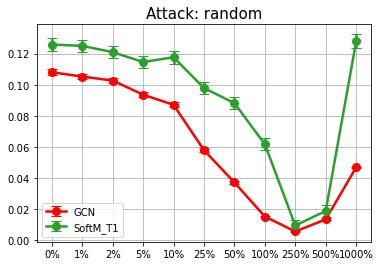

In [23]:
plot_ntk_model_diff(ntk_dict, y, eps_l, attack_params["attack"])

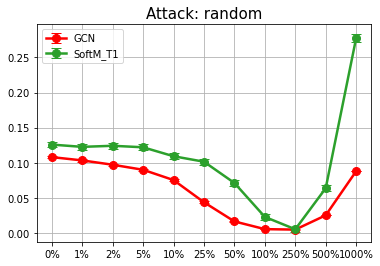

In [13]:
plot_ntk_model_diff(ntk_dict, y, eps_l, attack_params["attack"])

In [35]:
t = torch.tensor([[0., 0], [1., 2.]])
print(t)
t_grad = t.to_sparse(sparse_dim=2)
t_grad.requires_grad = True
t_dense = t_grad.to_dense()
print(t_dense)

tensor([[0., 0.],
        [1., 2.]])
tensor([[0., 0.],
        [1., 2.]], grad_fn=<ToDenseBackward0>)


In [36]:
t_grad

tensor(indices=tensor([[1, 1],
                       [0, 1]]),
       values=tensor([1., 2.]),
       size=(2, 2), nnz=2, layout=torch.sparse_coo, requires_grad=True)

In [37]:
ind = t.to_sparse(sparse_dim=2).indices()
weight = t.to_sparse(sparse_dim=2).values()
weight.requires_grad = True

In [39]:
t = torch.sparse_coo_tensor(*(ind, weight), 2*[2])

In [41]:
t.to_dense()

tensor([[0., 0.],
        [1., 2.]], grad_fn=<ToDenseBackward0>)